# Apr ??, 2022 ()

**Motivation**: 
<br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## E.g.

In [ ]:
mice = Mice(Config(128, 0))
mice.setup_func_data('rest')

num_k = 5
perc = 'p20-sample'

In [4]:
key = 'sub-SLC08_ses-1_run-5'
mode = 'ca2'
gr = Group(mice, num_k, mode=mode)
sv = SVINET(mice, num_k, perc, key, mode)
self = sv

current expt: 'p20-sample'

In [5]:
_ = sv.load_runs()

[PROGRESS] experiment loaded: 'k = 5, p20-sample',  total # runs:  1982

[PROGRESS] some runs were excluded:     18 x k = 4

In [6]:
dlist = []
for run_name, run_dict in sv._runs[sv.perc].items():
    stuff = {k: v for k, v in run_dict['valid'].items() if 'nll' in k}
    num_iter = np.unique([len(v) for v in stuff.values()]).item()
    for k, v in stuff.items():
        dlist.append({
            'score': v,
            'label': [k] * num_iter,
            'iter': range(num_iter),
            'run_name': [run_name] * num_iter,
        })
df = pd.DataFrame(merge_dicts(dlist))

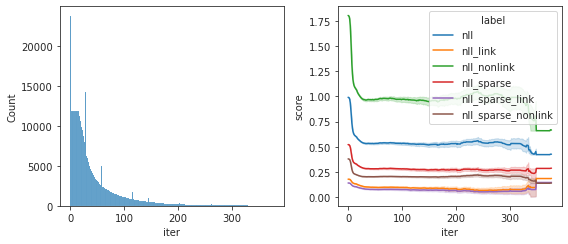

In [7]:
fig, axes = create_figure(1, 2, (8, 3.5))

sns.histplot(df['iter'], ax=axes[0])
sns.lineplot(data=df, x='iter', y='score', hue='label', ax=axes[1])
plt.show()

In [8]:
max_iter = 50
dlist = []
for run_name, run_dict in sv._runs[sv.perc].items():
    stuff = {k: v for k, v in run_dict['valid'].items() if 'nll' in k}
    num_iter = np.unique([len(v) for v in stuff.values()]).item()
    num_iter = min(num_iter, max_iter)
    for k, v in stuff.items():
        dlist.append({
            'key': [key] * num_iter,
            'run_name': [run_name] * num_iter,
            'score': v[:num_iter],
            'label': [k] * num_iter,
            'iter': range(num_iter),
        })
df = pd.DataFrame(merge_dicts(dlist))

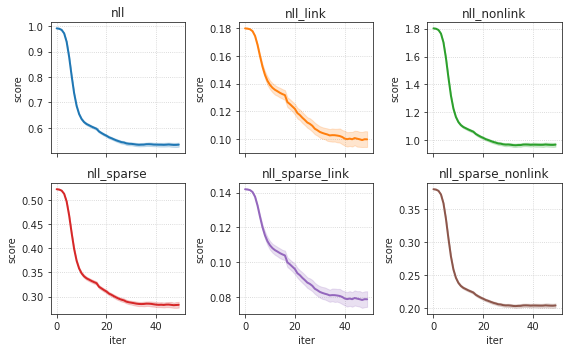

In [9]:
fig, axes = create_figure(2, 3, (8, 5), 'all')
for i, (ax, lbl) in enumerate(zip(axes.ravel(), df['label'].unique())):
    _df = df.loc[df['label'] == lbl]
    sns.lineplot(
        data=_df,
        x='iter',
        y='score',
        color=f"C{i}",
        lw=2,
        ax=ax,
    )
    ax.set_title(lbl)
    ax.grid()

In [10]:
df_avg = df.groupby(['label', 'iter']).mean().reset_index()

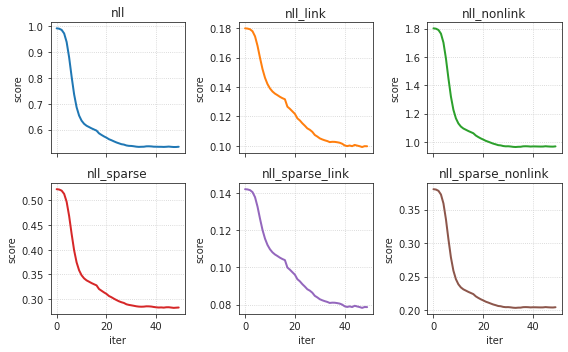

In [11]:
fig, axes = create_figure(2, 3, (8, 5), 'all')
for i, (ax, lbl) in enumerate(zip(axes.ravel(), df['label'].unique())):
    _df = df_avg.loc[df_avg['label'] == lbl]
    sns.lineplot(
        data=_df,
        x='iter',
        y='score',
        color=f"C{i}",
        lw=2,
        ax=ax,
    )
    ax.set_title(lbl)
    ax.grid()

In [12]:
_df = df_avg.loc[df_avg['iter'] == 0].drop(columns=['iter'])
results = dict(zip(_df['label'], _df['score']))
results

{
    'nll': 0.9911789977381433,
    'nll_link': 0.17993854509081736,
    'nll_nonlink': 1.8024194504041373,
    'nll_sparse': 0.5225219010958628,
    'nll_sparse_link': 0.14194490802825427,
    'nll_sparse_nonlink': 0.3805769930706357
}

## Do all k and all animals

In [2]:
mice = Mice(Config(128, 0))
mice.setup_func_data('rest', runs_only=True)

In [3]:
mode = 'ca2'
perc = 'p20-sample'
max_iter = 50
dlist = []
for num_k in tqdm(range(2, 9)):
    for key in tqdm(mice.ca, leave=False):
        sv = SVINET(mice, num_k, perc, key, mode, verbose=False)
        _ = sv.load_runs()
        data = collections.defaultdict(list)
        for run_name, run_dict in sv._runs[sv.perc].items():
            for lbl, vals in run_dict['valid'].items():
                if 'nll' not in lbl:
                    continue
                num = min(max_iter, len(vals))
                x = np_nans((1, max_iter))
                x[0][:num] = np.array(vals)[:num]
                data[lbl].append(x)
        data = {
            lbl: bn.nanmean(np.concatenate(x), 0)
            for lbl, x in data.items()
        } 
        for lbl, vals in data.items():
            dlist.append({
                'mode': [mode] * max_iter,
                'k': [num_k] * max_iter,
                'key': [key] * max_iter,
                'iter': range(max_iter),
                'label': [lbl] * max_iter,
                'score': vals,
            })
df = pd.DataFrame(merge_dicts(dlist))
df_0 = df.loc[df['iter'] == 0].drop(columns=['iter'])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

In [16]:
df.shape, df_0.shape

((243600, 6), (4872, 5))

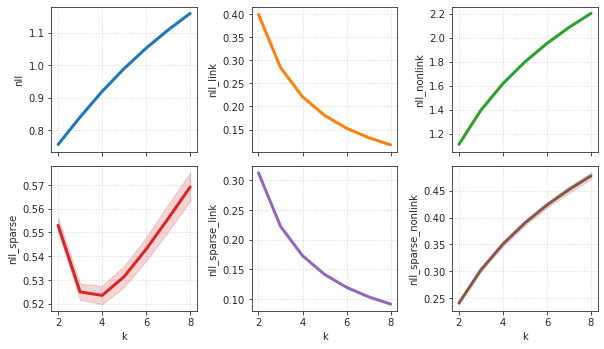

In [20]:
fig, axes = create_figure(2, 3, (8.5, 5), 'all')
for i, (ax, lbl) in enumerate(zip(axes.ravel(), df_0['label'].unique())):
    _df = df_0.loc[df_0['label'] == lbl]
    sns.lineplot(
        data=_df,
        x='k',
        y='score',
        color=f"C{i}",
        lw=3,
        ax=ax,
    )
    ax.set_ylabel(lbl)
    ax.grid()